**Economic Dispatch Seminar**

**Power Markets and Regulations 2024-2025**

**TA: Sahar Moghimian**

<!--NOTEBOOK_HEADER-->
*Most of the materials used for this notebook and our future seminars were developed by Prof. Michael Davidson and Prof. Jesse Jenkins and are used at the following courses:*

- *MAE / ENE 539 Optimization Methods for Energy Systems Engineering (Advanced Topics in Combustion I) [Princeton]*

- *MAE 243 Electric Power Systems Modeling [UC San Diego]*

*The full Github Repo with materials can be found* [here](https://github.com/Power-Systems-Optimization-Course/power-systems-optimization?tab=readme-ov-file#readme)

---
*This notebook has been adapted to Python/Pyomo and enhanced with real CAISO data, LMP extraction, and interactive exercises.*

# Economic Dispatch

_**[Power Systems Optimization](https://github.com/east-winds/power-systems-optimization)**_

_by Michael R. Davidson and Jesse D. Jenkins (last updated: October 4, 2022)_

This notebook will introduce a key operational model&mdash;economic dispatch (ED)&mdash;which minimizes the short-run production costs of meeting electricity demand from a given set of generators subject to various technical constraints.

We build up the model in several stages.

1. We begin with a single-time period and simple generator constraints just related to allowable output ranges. This allows us to compare the model with the intuition provided by the merit order supply curve (also known as the "dispatch stack").

2. We then add multiple time periods by considering the economic dispatch over an entire day. Due to the simple generator constraints, this simple model does not introduce any coupling across time.

3. More realism is added by considering engineering constraints that introduce time coupling&mdash;namely, ramp rates, which are an important limitation of many generators.

4. We examine the famous "duck curve" by adding more solar onto the system and explore the role that ramp rates play in the solution.

5. **NEW:** We extract **Locational Marginal Prices (LMPs)** from the demand constraint duals and compare with real CAISO market prices.

6. **NEW:** We compare our model results with **actual CAISO generation and demand data** from 2023-2024.

7. **NEW:** We "break the model" in several instructive ways and build a **comparison table** across all scenarios.

## Introduction to economic dispatch

Every day, system operators need to decide how to meet demand from a large variety of generators with different costs and engineering requirements. Prior to large-scale computational capabilities, this was accomplished by "priority lists" or similar heuristics to determine the ordering of plants. However, with modern optimization algorithms, operators can find the global minimum of production costs&mdash;and even incorporate coupling of engineering processes across time periods.

**Economic dispatch** (ED) is the problem of minimizing short-run costs of production in order to meet a given demand, considering relevant engineering constraints of the generators. It *does not* fully capture the physics of electricity flows, which will further constrain the feasible space and which we will come back to in later notebooks on optimal power flow, nor does it account for decisions and constraints related to turning on or "committing" large thermal generators, which we'll discuss in our next notebook on unit commitment. Typically, *it does* incorporate some type of network representation, which we have ignored here by considering only a single bus. More on the networks in the notebook on optimal power flow.

## Single-time period, simple generator constraints

We will first examine the case where we are optimizing dispatch for a single snapshot in time, with only very simple constraints on the generators.
    
$$
\begin{align}
\min \ & \sum_{g \in G} VarCost_g \times GEN_g & \\
\text{s.t.} & \\
 & \sum_{g} GEN_g = Demand & \\
 & GEN_g \leq Pmax_g & \forall \quad g \in G \\
 & GEN_g \geq Pmin_g & \forall \quad g \in G \\
\end{align}
$$

The **decision variable** in the above problem is:

- $GEN_{g}$, the generation (in MW) produced by each generator, $g$

The **parameters** are:

- $Pmin_g$, the minimum operating bounds for the generator (based on engineering or natural resource constraints)
- $Pmax_g$, the maximum operating bounds for the generator (based on engineering or natural resource constraints)
- $Demand$, the demand (in MW)

(For this simple problem, we will let $Pmin_g=0$ and revisit this later in the unit commitment notebook.)

In addition, we have:

$$
VarCost_g = VarOM_g + HeatRate_g \times FuelCost_g
$$

- **VarOM_g**: This is the variable operation and maintenance cost per unit of energy produced (typically per megawatt-hour, or MWh). It covers costs that vary with production levels, such as maintenance that scales with wear and tear from generation.

- **HeatRate$_g$**: This represents the efficiency of the generator and is given in MMBtu/MWh (million British thermal units per megawatt-hour). It tells us how much fuel energy is needed to produce one MWh of electricity. A lower heat rate means higher efficiency.

- **FuelCost$_g$**: This is the cost of fuel per MMBtu for the generator.

Note that, in contrast with the basic capacity expansion problem (long term planning), we are not concerned with fixed costs.

Why not?

The simplest response is that these costs have already been incurred and regardless of how much a generator produces, its fixed costs will not change. These costs are thus "[sunk costs](https://en.wikipedia.org/wiki/Sunk_cost)" and are constant in the objective function. Our optimal decision variables would not change by adjusting this constant up or down. Therefore, we can safely ignore fixed costs for the purposes of finding optimal dispatch. (We will still have to consider them to calculate producer profits, however.)

> [A famous electricity regulator](https://en.wikipedia.org/wiki/Ignacio_J._P%C3%A9rez_Arriaga), noting that it is frequently misunderstood and ignored even by experienced market participants, has called the application of the "[sunk cost fallacy](https://en.wikipedia.org/wiki/Sunk_cost#Fallacy_effect)" to electricity systems "[Grandma's Inheritance Theorem](http://link.springer.com/content/pdf/bbm%3A978-1-4471-5034-3%2F1.pdf)." In this hypothetical scenario, if you were to inherit a diamond ring or perhaps a financial contract-for-differences that pays out relative to cleared market prices (you have a very sophisticated grandma in this scenario!), you should not be tempted to change your production strategy.

Now, let's implement ED.

### 1. Install and load packages

In [38]:
# Install required packages (run this cell once)
!pip install -q pyomo highspy pandas matplotlib plotly gridstatus


[notice] A new release of pip is available: 26.0 -> 26.0.1
[notice] To update, run: pip install --upgrade pip


In [39]:
import pyomo.environ as pyo
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import warnings
warnings.filterwarnings('ignore')

pd.set_option('display.max_columns', 120)
pd.set_option('display.width', 120)

### 2. Load and format data

We will use data based on San Diego Gas and Electric (SDG&E, via the [PowerGenome](https://github.com/gschivley/PowerGenome) data platform) plus a few neighboring generators, consisting of:

- 25 generators (including some clustering of smaller generators, and excluding behind-the-meter solar)
- estimated hourly demand for 2020 (net load at the transmission substation level after subtracting 600MW of behind-the-meter solar from original demand)
- variable generation capacity factors
- estimated natural gas fuel costs

In [40]:
base_url = "https://raw.githubusercontent.com/Power-Systems-Optimization-Course/power-systems-optimization/master/Notebooks/ed_data/"

gen_info = pd.read_csv(base_url + "Generators_data.csv")
fuels = pd.read_csv(base_url + "Fuels_data.csv")
loads = pd.read_csv(base_url + "Demand.csv")
gen_variable = pd.read_csv(base_url + "Generators_variability.csv")

# Rename all columns to lowercase (by convention)
for df in [gen_info, fuels, loads, gen_variable]:
    df.columns = df.columns.str.lower()

**Construct generator dataframe**

In [41]:
# Keep only the columns relevant to our ED model
gen_info = gen_info.iloc[:, list(range(26)) + [gen_info.columns.get_loc('stor')]]
gen_df = gen_info.merge(fuels, on='fuel', how='outer')  # load in fuel costs
gen_df.rename(columns={'cost_per_mmbtu': 'fuel_cost'}, inplace=True)
gen_df['fuel_cost'] = gen_df['fuel_cost'].fillna(0)

# Create "is_variable" column to indicate if this is a variable generation source
variable_resources = ['onshore_wind_turbine', 'small_hydroelectric', 'solar_photovoltaic']
gen_df['is_variable'] = gen_df['resource'].isin(variable_resources)

# Create full name of generator (including geographic location and cluster number)
gen_df['gen_full'] = (gen_df['region'] + '_' + gen_df['resource'] + '_' + gen_df['cluster'].astype(str) + '.0').str.lower()

# Remove generators with no capacity (new build options for capacity expansion)
gen_df = gen_df[gen_df['existing_cap_mw'] > 0].reset_index(drop=True)

### Long and wide data format example

In [42]:
gen_df.iloc[:5, :5]

,r_id,resource,region,existing_cap_mw,num_units
0,3,natural_gas_fired_combined_cycle,WEC_SDGE,607.1,1
1,4,natural_gas_fired_combined_cycle,WEC_SDGE,30.0,1
2,5,natural_gas_fired_combined_cycle,WEC_SDGE,49.4,1
3,6,natural_gas_fired_combined_cycle,WEC_SDGE,570.0,1
4,7,natural_gas_fired_combined_cycle,WEC_SDGE,336.0,3


In [43]:
# Convert from wide to long format (equivalent to Julia's stack)
df = gen_df.iloc[:5, :5].copy()
df_long = df.melt(
    id_vars=['r_id', 'resource', 'region'],
    value_vars=['existing_cap_mw', 'num_units'],
    var_name='var',
    value_name='val'
)
df_long

,r_id,resource,region,var,val
0,3,natural_gas_fired_combined_cycle,WEC_SDGE,existing_cap_mw,607.1
1,4,natural_gas_fired_combined_cycle,WEC_SDGE,existing_cap_mw,30.0
2,5,natural_gas_fired_combined_cycle,WEC_SDGE,existing_cap_mw,49.4
3,6,natural_gas_fired_combined_cycle,WEC_SDGE,existing_cap_mw,570.0
4,7,natural_gas_fired_combined_cycle,WEC_SDGE,existing_cap_mw,336.0
5,3,natural_gas_fired_combined_cycle,WEC_SDGE,num_units,1.0
6,4,natural_gas_fired_combined_cycle,WEC_SDGE,num_units,1.0
7,5,natural_gas_fired_combined_cycle,WEC_SDGE,num_units,1.0
8,6,natural_gas_fired_combined_cycle,WEC_SDGE,num_units,1.0
9,7,natural_gas_fired_combined_cycle,WEC_SDGE,num_units,3.0


**Modify load and variable generation dataframes**

1. Convert from GMT to GMT-8

The load and variable generation files are in GMT. We want to convert to local California time. Here, we will ignore daylight savings and simply subtract 8 hours.

To accomplish this, we 'wrap' the last 8 hours of the data series around to the front of the series.

In [44]:
gen_variable['hour'] = (gen_variable['hour'] - 9) % 8760 + 1
gen_variable = gen_variable.sort_values('hour').reset_index(drop=True)

loads['hour'] = (loads['hour'] - 9) % 8760 + 1
loads = loads.sort_values('hour').reset_index(drop=True)

2. Convert from "wide" to "long" format:

The file is in "wide" format, which has separate columns for values from different types of generators. This has more human readability, but often we want to have it in "long" format for computation.

"Long" format refers to a dataframe with a separate row entry for every value. In Python, we use the pandas [`melt`](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.melt.html) function to accomplish this.

In [45]:
gen_variable_long = gen_variable.melt(
    id_vars='hour',
    var_name='gen_full',
    value_name='cf'
)

# Let's look at the first 6 entries of a wind resource for example
gen_variable_long[gen_variable_long['gen_full'] == 'wec_sdge_onshore_wind_turbine_1.0'].head(6)

,hour,gen_full,cf
157680,1,wec_sdge_onshore_wind_turbine_1.0,0.1694
157681,2,wec_sdge_onshore_wind_turbine_1.0,0.1658
157682,3,wec_sdge_onshore_wind_turbine_1.0,0.1502
157683,4,wec_sdge_onshore_wind_turbine_1.0,0.1455
157684,5,wec_sdge_onshore_wind_turbine_1.0,0.0932
157685,6,wec_sdge_onshore_wind_turbine_1.0,0.0717


**Extract single time from the data**
(we will get to the full set later)

- demand
- variable generation

Note: variable generation profiles are often encoded in terms of hourly maximum capacity factor, expressed as a per unit value or percentage of installed capacity. Hourly capacity factor is then later multiplied by installed capacity to yield a maximum hourly generation for each resource.

In [46]:
hr = 2416  # pick 4pm on a spring day
loads_single = loads[loads['hour'] == hr].drop(columns='hour')
var_cf_single = gen_variable_long[gen_variable_long['hour'] == hr].drop(columns='hour')
var_cf_single

,gen_full,cf
2415,wec_sdge_biomass_1.0,1.000000
11175,wec_sdge_hydroelectric_pumped_storage_1.0,1.000000
19935,wec_sdge_natural_gas_fired_combined_cycle_1.0,1.000000
28695,wec_sdge_natural_gas_fired_combined_cycle_2.0,1.000000
37455,wec_sdge_natural_gas_fired_combined_cycle_3.0,1.000000
46215,wec_sdge_natural_gas_fired_combined_cycle_4.0,1.000000
54975,wec_sdge_natural_gas_fired_combustion_turbine_1.0,1.000000
63735,wec_sdge_natural_gas_fired_combustion_turbine_2.0,1.000000
72495,wec_sdge_natural_gas_fired_combustion_turbine_3.0,1.000000
81255,wec_sdge_natural_gas_fired_combustion_turbine_4.0,1.000000


---
### Quiz 1: Before we solve

**Think about the following before running the next cells:**

1. Looking at the generator data, which generators do you expect to be dispatched first? Why?
2. If demand is ~2,500 MW, do we need *all* generators to meet it?
3. What is the variable cost of solar and wind generation? What does this imply for their position in the merit order?

*Write down your answers, then continue to see if the model confirms your intuition.*

---

### Quiz 1 -- Answer Key

**1. Which generators do you expect to be dispatched first? Why?**

Solar, wind, and hydro are dispatched first because they have **zero fuel cost** (no heat rate × fuel cost component) and very low variable O&M costs. Among thermal generators, the most efficient **combined cycle** plants are next:
- r_id=6 (CC, heat rate 7.15 MMBtu/MWh) → variable cost ≈ $26.50/MWh
- r_id=3 (CC, heat rate 7.52 MMBtu/MWh) → variable cost ≈ $27.80/MWh

The expensive **combustion turbines** (heat rates 9–13 MMBtu/MWh) are dispatched last because they have the highest variable costs ($40–60+/MWh).

This ordering is the **merit order**: generators are stacked from cheapest to most expensive.

**2. If demand is ~2,500 MW, do we need all generators to meet it?**

No. Total installed capacity is ~3,400 MW, well above demand. The most expensive peakers (combustion turbines at the right end of the supply curve) will have GEN = 0. Only generators to the left of the demand line on the supply curve are dispatched.

**3. What is the variable cost of solar and wind? What does this imply?**

Solar and wind have **zero variable cost** (no fuel needed). This places them at the far left of the merit order — they are always dispatched first. They are paid the market clearing price (LMP), which is set by the *marginal* gas generator, so they earn the **full LMP as profit** (called "inframarginal rent"). This is a key incentive for renewable investment under marginal-cost pricing.

### 3. Create solver function

Here, we introduce a functionalized version of the optimization problem. We pass the problem parameters to the function, and it constructs and solves the model, returning the result. This will be useful when we wish to call the same basic model multiple times, e.g. for conducting sensitivities on parameters.

We use the **HiGHS** solver (high performance software for linear optimization): for large-scale sparse linear programming (LP), mixed-integer programming (MIP), and quadratic programming (QP) models.

In [47]:
def economic_dispatch_single(gen_df, loads, gen_variable):
    """
    Solve economic dispatch problem (single-time period, single-zone).
    
    Parameters:
        gen_df       -- DataFrame with generator info
        loads        -- DataFrame with load info (single row)
        gen_variable -- capacity factors of variable generators (in 'long' format)
    """
    model = pyo.ConcreteModel()
    model.dual = pyo.Suffix(direction=pyo.Suffix.IMPORT)

    # Sets
    G_var = list(gen_df[gen_df['is_variable'] == True]['r_id'])
    G_nonvar = list(gen_df[gen_df['is_variable'] == False]['r_id'])
    G = list(gen_df['r_id'])
    model.G = pyo.Set(initialize=G)

    # Generator capacity factor for variable generators
    gen_var_cf = gen_variable.merge(
        gen_df[gen_df['is_variable'] == True][['r_id', 'gen_full', 'existing_cap_mw']],
        on='gen_full', how='inner'
    )

    gen_lookup = gen_df.set_index('r_id')

    # Decision variables
    model.GEN = pyo.Var(model.G, within=pyo.NonNegativeReals)

    # Objective function
    def obj_rule(m):
        return (
            sum(
                (gen_lookup.loc[i, 'heat_rate_mmbtu_per_mwh'] * gen_lookup.loc[i, 'fuel_cost'] +
                 gen_lookup.loc[i, 'var_om_cost_per_mwh']) * m.GEN[i]
                for i in G_nonvar
            ) +
            sum(
                gen_lookup.loc[i, 'var_om_cost_per_mwh'] * m.GEN[i]
                for i in G_var
            )
        )
    model.objective = pyo.Objective(rule=obj_rule, sense=pyo.minimize)

    # Demand constraint
    demand_val = loads.iloc[0]['demand']
    model.cDemand = pyo.Constraint(
        expr=sum(model.GEN[i] for i in G) == demand_val
    )

    # Capacity constraint (non-variable generation)
    model.cap_nonvar = pyo.ConstraintList()
    for i in G_nonvar:
        model.cap_nonvar.add(model.GEN[i] <= gen_lookup.loc[i, 'existing_cap_mw'])

    # Variable generation capacity constraint
    model.cap_var = pyo.ConstraintList()
    for _, row in gen_var_cf.iterrows():
        model.cap_var.add(model.GEN[row['r_id']] <= row['cf'] * row['existing_cap_mw'])

    # Solve
    solver = pyo.SolverFactory('appsi_highs')
    result = solver.solve(model, tee=True)

    # Check feasibility
    status = str(result.solver.termination_condition)
    if status != 'optimal':
        print(f"\n*** WARNING: Solver status = {status} ***")
        return {'solution': pd.DataFrame(), 'cost': None, 'price': None, 'status': status}

    # Extract solution
    solution = pd.DataFrame({
        'r_id': gen_df['r_id'].values,
        'resource': gen_df['resource'].values,
        'gen': [pyo.value(model.GEN[i]) for i in gen_df['r_id']]
    })

    # Extract LMP (dual of demand constraint = market clearing price)
    try:
        lmp = model.dual[model.cDemand]
    except KeyError:
        lmp = None

    return {
        'solution': solution,
        'cost': pyo.value(model.objective),
        'price': lmp,
        'status': status,
    }

### 4. Solve and print data

In [48]:
solution = economic_dispatch_single(gen_df, loads_single, var_cf_single)

In [49]:
solution['solution']

,r_id,resource,gen
0,3,natural_gas_fired_combined_cycle,607.100000
1,4,natural_gas_fired_combined_cycle,30.000000
2,5,natural_gas_fired_combined_cycle,49.400000
3,6,natural_gas_fired_combined_cycle,570.000000
4,7,natural_gas_fired_combined_cycle,336.000000
5,8,natural_gas_fired_combined_cycle,336.000000
6,9,natural_gas_fired_combustion_turbine,0.000000
7,10,natural_gas_fired_combustion_turbine,49.900000
8,11,natural_gas_fired_combustion_turbine,0.000000
9,12,natural_gas_fired_combustion_turbine,0.000000


In [50]:
sol = solution['solution']
print(f"Total cost: ${solution['cost']:,.2f}")
print(f"Market clearing price (LMP): ${solution['price']:.2f}/MWh")
print(f"\nMax generation: {sol.loc[sol['gen'].idxmax(), 'resource']} = {sol['gen'].max():.1f} MW")
print(f"Generators at zero: {(sol['gen'] == 0).sum()} out of {len(sol)}")

Total cost: $58,477.78
Market clearing price (LMP): $37.78/MWh

Max generation: natural_gas_fired_combined_cycle = 607.1 MW
Generators at zero: 12 out of 25


### Understanding the LMP (Locational Marginal Price)

The **dual value** of the demand constraint tells us the **marginal cost of serving one additional MW of demand**. In a single-bus model like ours, this is the system-wide electricity price, equivalent to the variable cost of the *marginal generator*.

This is exactly how wholesale electricity markets work: all generators are paid the **market clearing price** (the price set by the most expensive generator that is dispatched), not their individual costs.

We will explore LMPs more thoroughly in later sections. For now, note that the LMP equals the variable cost of the marginal generator on the supply curve.

We will now plot the **supply curve** (also known as the **dispatch stack**) for this single period to illustrate the concept of **merit order**.

In [51]:
supply_curve = gen_df.merge(var_cf_single, on='gen_full', how='left')
supply_curve['varcost'] = 0.0
supply_curve['cap'] = 0.0

# Variable cost and capacity for non-variable generators
nonvar_mask = supply_curve['is_variable'] == False
supply_curve.loc[nonvar_mask, 'varcost'] = (
    supply_curve.loc[nonvar_mask, 'heat_rate_mmbtu_per_mwh'] *
    supply_curve.loc[nonvar_mask, 'fuel_cost'] +
    supply_curve.loc[nonvar_mask, 'var_om_cost_per_mwh']
)
supply_curve.loc[nonvar_mask, 'cap'] = supply_curve.loc[nonvar_mask, 'existing_cap_mw']

# Variable cost and capacity for variable generators
var_mask = supply_curve['is_variable'] == True
supply_curve.loc[var_mask, 'varcost'] = supply_curve.loc[var_mask, 'var_om_cost_per_mwh']
supply_curve.loc[var_mask, 'cap'] = (
    supply_curve.loc[var_mask, 'existing_cap_mw'] * supply_curve.loc[var_mask, 'cf']
)

supply_curve = supply_curve.sort_values('varcost').reset_index(drop=True)

Now, let's plot this as a supply curve where:

- width = capacity of the generator (i.e., $Pmax$)
- height = variable cost of the generator ($VarCost$)

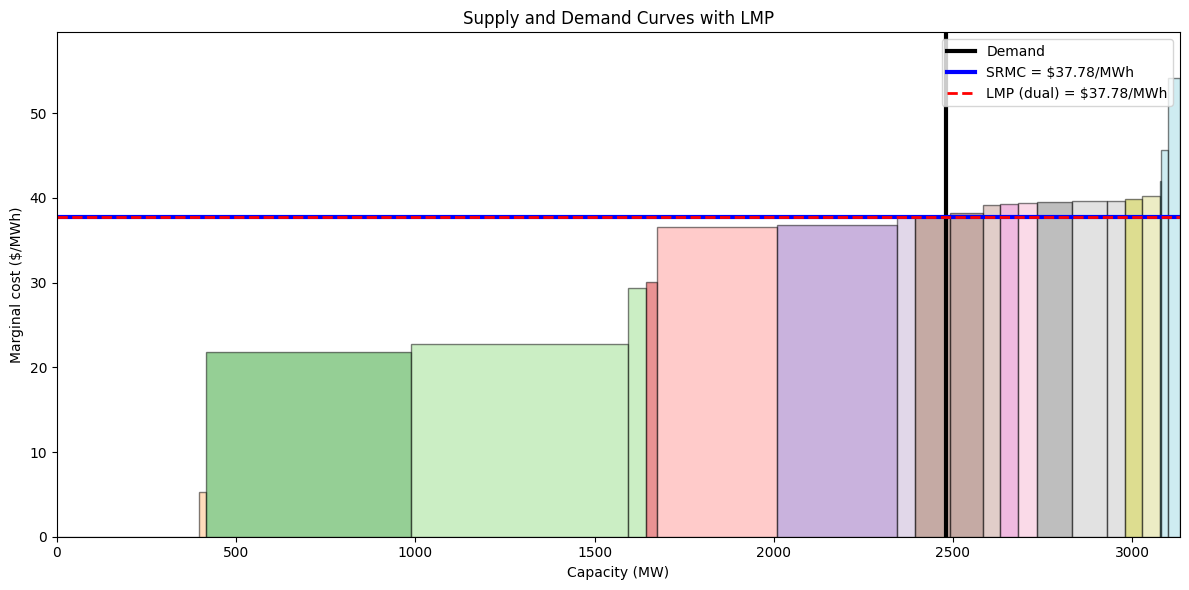

In [52]:
fig, ax = plt.subplots(figsize=(12, 6))

demand_val = loads_single.iloc[0]['demand']
marg_gen = 0
marg_price = 0
x = 0

colors = plt.cm.tab20(np.linspace(0, 1, len(supply_curve)))

for idx in range(len(supply_curve)):
    width = supply_curve.iloc[idx]['cap']
    height = supply_curve.iloc[idx]['varcost']
    rect = mpatches.FancyBboxPatch((x, 0), width, height, alpha=0.5,
                                    boxstyle="square,pad=0", facecolor=colors[idx])
    ax.add_patch(rect)
    if x < demand_val and x + width > demand_val:
        marg_gen = idx
        marg_price = height
    x += width

ax.axvline(x=demand_val, color='black', linewidth=3, label='Demand')
ax.axhline(y=marg_price, color='blue', linewidth=3, label=f'SRMC = ${marg_price:.2f}/MWh')
ax.axhline(y=solution['price'], color='red', linewidth=2, linestyle='--', label=f'LMP (dual) = ${solution["price"]:.2f}/MWh')
ax.set_xlim(0, x)
ax.set_ylim(0, supply_curve['varcost'].max() * 1.1)
ax.set_xlabel('Capacity (MW)')
ax.set_ylabel('Marginal cost ($/MWh)')
ax.set_title('Supply and Demand Curves with LMP')
ax.legend(loc='upper right')
plt.tight_layout()
plt.show()

In the above, everything to the left of demand is dispatched at full capacity, except for the last generator (the "marginal generator") where demand stops. Everything to the right is not dispatched (=0). Note that the **LMP (red dashed) matches the SRMC (blue)** of the marginal generator.

In [53]:
print("Marginal generator:")
supply_curve.iloc[marg_gen][['r_id', 'resource', 'varcost', 'existing_cap_mw']]

Marginal generator:


r_id                                                 13
resource           natural_gas_fired_combustion_turbine
varcost                                          37.785
existing_cap_mw                                    96.6
Name: 12, dtype: object

In [54]:
marg_rid = supply_curve.iloc[marg_gen]['r_id']
marg_dispatch = solution['solution'][solution['solution']['r_id'] == marg_rid]['gen'].values[0]
print(f"Marginal generator dispatch: {marg_dispatch:.1f} MW (out of {supply_curve.iloc[marg_gen]['cap']:.1f} MW available)")

Marginal generator dispatch: 86.9 MW (out of 96.6 MW available)


**Combine by generation type**

In [55]:
sol_gen = solution['solution'].groupby('resource', as_index=False)['gen'].sum()
sol_gen.rename(columns={'gen': 'gen_sum'}, inplace=True)

# Add back BTM solar
btm_cf = var_cf_single[var_cf_single['gen_full'] == 'wec_sdge_solar_photovoltaic_1.0']['cf'].values[0]
btm = pd.DataFrame({'resource': ['solar_photovoltaic_btm'], 'gen_sum': [btm_cf * 600]})
sol_gen_btm = pd.concat([sol_gen, btm], ignore_index=True)
sol_gen_btm.round(3)

,resource,gen_sum
0,biomass,21.400
1,hydroelectric_pumped_storage,42.000
2,natural_gas_fired_combined_cycle,1928.500
3,natural_gas_fired_combustion_turbine,136.755
4,onshore_wind_turbine,65.411
5,small_hydroelectric,3.185
6,solar_photovoltaic,284.750
7,solar_photovoltaic_btm,341.700


Hence, the majority of energy is being met by combined cycle natural gas turbines (CCGT), second by solar PV, and third by behind-the-meter solar.

---
### Quiz 2: Interpreting the LMP

**Think about these questions:**

1. The LMP (market clearing price) is set by the marginal generator. If demand *increases* by 100 MW, which generator would supply the extra power? Would the LMP change?
2. Solar and wind generators have zero (or near-zero) variable cost. Under this market design, at what price are they paid? Is this above or below their variable cost? What does this mean for their profits?
3. If we *doubled* the solar capacity, what would happen to the LMP at this hour? (Think about which generator becomes marginal.)

*We will verify answer #3 later in the duck curve section.*

---

### Quiz 2 -- Answer Key

**1. If demand increases by 100 MW, which generator supplies it? Would the LMP change?**

The **marginal generator** (the one currently partially dispatched) would supply the additional 100 MW — as long as it has enough remaining capacity. If it does, the LMP stays the same (same generator sets the price). If the extra 100 MW pushes us past the marginal generator's capacity, the *next* generator on the merit order becomes marginal, and the LMP **increases** to that generator's higher variable cost.

**2. Solar and wind are paid the LMP. What does this mean for their profits?**

All generators — including solar and wind — are paid the **market clearing price (LMP)**, not their individual cost. Since solar/wind have ~$0 variable cost but receive the LMP (set by a gas plant, e.g., ~$28/MWh), their profit per MWh equals the full LMP. This profit is called **inframarginal rent** and is how generators recover their fixed/capital costs under marginal-cost pricing. Renewables earn the highest inframarginal rent because their variable cost is effectively zero.

**3. If we doubled solar capacity, what happens to the LMP?**

More solar pushes the merit order further to the right — cheap solar displaces expensive gas generation. The marginal generator shifts to a **cheaper** unit on the supply curve, so the **LMP decreases**. In the extreme case (solar exceeds demand), the LMP could drop to $0 or even go negative. We will see this in the duck curve section.

## Multiple-time period, simple generator constraints

We neglected the time dimension above and now we will add it back in. The key changes to the model arise from adding an additional index for time:

$$
\begin{align}
\min \ & \sum_{g \in G, t \in T} VarCost_g \times GEN_{g,t} & \\
\text{s.t.} & \\
 & \sum_{g} GEN_{g,t} = Demand_t & \forall \quad t \in T \\
 & GEN_{g,t} \leq Pmax_{g,t} & \forall \quad g \in G , t \in T \\
 & GEN_{g,t} \geq Pmin_{g,t} & \forall \quad g \in G , t \in T
\end{align}
$$


Note that for conventional generators, we often have $Pmax_{g,t} = Pmax_{g}$ and $Pmin_{g,t} = Pmin_{g}$ constant over time. (We will consider unit commitment later, which will alter this logic.)

For variable renewable generators, it is natural that $Pmax_{g,t}$ varies with time (i.e., based on solar irradiation or wind speeds). $Pmin_{g,t}$ for wind and solar resources is usually 0, but for hydropower resources, minimum streamflow constraints can produce a time-variant parameter.

---
### Quiz 3: Before adding time

**Predict:**

1. At what hour of the day do you expect demand to be highest? Lowest?
2. At what hour do you expect the electricity price (LMP) to be highest? Is it the same hour as peak demand?
3. Without ramp constraints, can we solve each hour independently? Why or why not?

---

### Quiz 3 -- Answer Key

**1. At what hour is demand highest? Lowest?**

- **Highest demand**: Late afternoon / early evening (around 5–7 PM, hours 17–19). This is when people come home, turn on appliances, AC, lighting, and cooking — while commercial/industrial load is still running.
- **Lowest demand**: Early morning (around 3–5 AM, hours 3–5). Most residential and commercial activity is minimal.

**2. At what hour is the LMP highest? Is it the same as peak demand?**

Not necessarily the same hour. The LMP depends on which generator is *marginal*, which depends on both **demand** and **available renewable generation**. On a sunny spring day:
- Even though demand peaks in the evening, midday solar reduces the net load significantly, so the LMP may be *lowest* at midday.
- The **highest LMP** occurs in the evening when solar drops off and demand remains high — expensive gas plants must be dispatched.
- So peak LMP can occur *after* peak demand, during the evening ramp when solar is gone but demand is still elevated.

**3. Without ramp constraints, can we solve each hour independently?**

**Yes.** Without ramp constraints, there is no coupling between time periods — each hour's constraints involve only variables from that hour. The problem is **separable**: we could solve 24 independent single-period problems and get the same result as the multi-period formulation. This changes once we add ramp constraints, which link GEN(g, t) to GEN(g, t+1).

### 3. Create solver function

(We reuse steps 1 and 2 above to load packages and data.)

In [56]:
def economic_dispatch_multi(gen_df, loads, gen_variable):
    """
    Solve economic dispatch problem (multi-time period, single-zone).
    Returns solution, cost, hourly LMPs, and solver status.
    """
    model = pyo.ConcreteModel()
    model.dual = pyo.Suffix(direction=pyo.Suffix.IMPORT)

    # Define sets
    G_var = list(gen_df[gen_df['is_variable'] == True]['r_id'])
    G_nonvar = list(gen_df[gen_df['is_variable'] == False]['r_id'])
    G = list(gen_df['r_id'])
    T = list(loads['hour'])

    model.G = pyo.Set(initialize=G)
    model.T = pyo.Set(initialize=T)

    gen_var_cf = gen_variable.merge(
        gen_df[gen_df['is_variable'] == True][['r_id', 'gen_full', 'existing_cap_mw']],
        on='gen_full', how='inner'
    )

    gen_lookup = gen_df.set_index('r_id')
    loads_lookup = loads.set_index('hour')

    # Decision variables
    model.GEN = pyo.Var(model.G, model.T, within=pyo.NonNegativeReals)

    # Objective function
    def obj_rule(m):
        return (
            sum(
                (gen_lookup.loc[i, 'heat_rate_mmbtu_per_mwh'] * gen_lookup.loc[i, 'fuel_cost'] +
                 gen_lookup.loc[i, 'var_om_cost_per_mwh']) * m.GEN[i, t]
                for i in G_nonvar for t in T
            ) +
            sum(
                gen_lookup.loc[i, 'var_om_cost_per_mwh'] * m.GEN[i, t]
                for i in G_var for t in T
            )
        )
    model.objective = pyo.Objective(rule=obj_rule, sense=pyo.minimize)

    # Demand constraint
    model.cDemand = pyo.Constraint(model.T)
    for t in T:
        model.cDemand[t] = sum(model.GEN[i, t] for i in G) == loads_lookup.loc[t, 'demand']

    # Capacity constraints (non-variable generation)
    model.cap_nonvar = pyo.ConstraintList()
    for i in G_nonvar:
        for t in T:
            model.cap_nonvar.add(model.GEN[i, t] <= gen_lookup.loc[i, 'existing_cap_mw'])

    # Variable generation capacity constraints
    model.cap_var = pyo.ConstraintList()
    for _, row in gen_var_cf.iterrows():
        model.cap_var.add(
            model.GEN[row['r_id'], row['hour']] <= row['cf'] * row['existing_cap_mw']
        )

    # Solve
    solver = pyo.SolverFactory('appsi_highs')
    result = solver.solve(model, tee=True)

    status = str(result.solver.termination_condition)
    if status != 'optimal':
        print(f"\n*** WARNING: Solver status = {status} ***")
        return {'solution': pd.DataFrame(), 'cost': None, 'lmps': pd.DataFrame(), 'status': status}

    # Extract solution
    records = []
    for i in G:
        for t in T:
            records.append({'r_id': i, 'hour': t, 'gen': pyo.value(model.GEN[i, t])})
    solution_df = pd.DataFrame(records)

    # Extract hourly LMPs
    lmps = pd.DataFrame({
        'hour': T,
        'lmp': [model.dual[model.cDemand[t]] for t in T]
    })

    return {
        'solution': solution_df,
        'cost': pyo.value(model.objective),
        'lmps': lmps,
        'status': status,
    }

### 4. Solve a day's economic dispatch

We will subset our year-long dataset to a single spring day and solve.

In [57]:
n = 100
T_period = list(range(n * 24 + 1, (n + 1) * 24 + 1))

loads_multi = loads[loads['hour'].isin(T_period)].copy()
gen_variable_multi = gen_variable_long[gen_variable_long['hour'].isin(T_period)].copy()

gen_df_sens = gen_df.copy()

solution_multi = economic_dispatch_multi(gen_df_sens, loads_multi, gen_variable_multi)

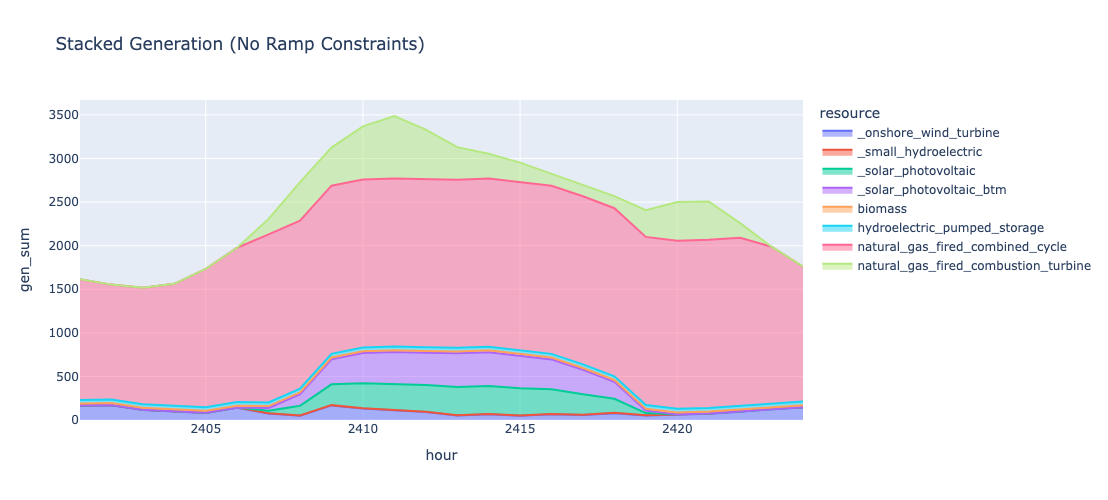

In [58]:
# Process and plot results with BTM solar
def process_and_plot(solution, gen_df, gen_variable_multi, T_period, title=''):
    """Helper to add BTM solar and create stacked area plot."""
    sol_gen = solution['solution'].merge(gen_df[['r_id', 'resource']], on='r_id')
    sol_gen = sol_gen.groupby(['resource', 'hour'], as_index=False)['gen'].sum()
    sol_gen.rename(columns={'gen': 'gen_sum'}, inplace=True)

    sol_gen_btm = sol_gen.copy()
    sol_gen_btm.loc[sol_gen_btm['resource'] == 'solar_photovoltaic', 'resource'] = '_solar_photovoltaic'
    sol_gen_btm.loc[sol_gen_btm['resource'] == 'onshore_wind_turbine', 'resource'] = '_onshore_wind_turbine'
    sol_gen_btm.loc[sol_gen_btm['resource'] == 'small_hydroelectric', 'resource'] = '_small_hydroelectric'

    btm_cf = gen_variable_multi[gen_variable_multi['gen_full'] == 'wec_sdge_solar_photovoltaic_1.0'][['hour', 'cf']].copy()
    btm = pd.DataFrame({
        'resource': '_solar_photovoltaic_btm',
        'hour': btm_cf['hour'].values,
        'gen_sum': btm_cf['cf'].values * 600
    })
    sol_gen_btm = pd.concat([sol_gen_btm, btm], ignore_index=True)
    sol_gen_btm = sol_gen_btm.sort_values(['hour', 'resource']).reset_index(drop=True)

    fig = px.area(sol_gen_btm, x='hour', y='gen_sum', color='resource',
                  title=title or 'Stacked Generation by Resource',
                  width=1000, height=500)
    fig.show()
    return sol_gen_btm

sol_gen_btm_base = process_and_plot(solution_multi, gen_df, gen_variable_multi, T_period,
                                     'Stacked Generation (No Ramp Constraints)')

### Hourly LMPs (Electricity Prices)

Now let's plot the hourly electricity prices alongside demand. The LMP at each hour is the dual of the demand balance constraint.

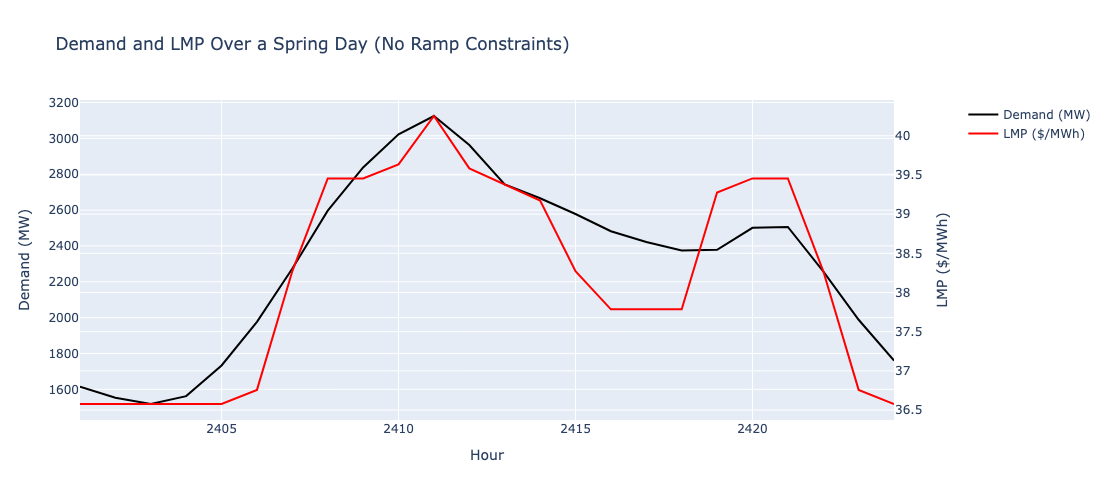

In [59]:
fig = make_subplots(specs=[[{"secondary_y": True}]])

fig.add_trace(
    go.Scatter(x=loads_multi['hour'], y=loads_multi['demand'],
               name='Demand (MW)', line=dict(color='black', width=2)),
    secondary_y=False
)

fig.add_trace(
    go.Scatter(x=solution_multi['lmps']['hour'], y=solution_multi['lmps']['lmp'],
               name='LMP ($/MWh)', line=dict(color='red', width=2)),
    secondary_y=True
)

fig.update_layout(title='Demand and LMP Over a Spring Day (No Ramp Constraints)',
                  width=1000, height=500)
fig.update_xaxes(title_text='Hour')
fig.update_yaxes(title_text='Demand (MW)', secondary_y=False)
fig.update_yaxes(title_text='LMP ($/MWh)', secondary_y=True)
fig.show()

Notice how the LMP changes throughout the day as different generators become marginal. During midday when solar is abundant, cheaper generators are marginal. During evening peak demand, more expensive generators must be dispatched.

## Multiple-time period, complex generator constraints with time coupling

The above problem did not include more than one time index per constraint. Hence, we could actually solve this each time period separately without regard to what is happening before or after. (These are known as "separable" problems.)

We now introduce time coupling into the model, by considering ramp rates, which limit how much generators can change output from one period to the next (an engineering constraint).

The new model:

$$
\begin{align}
\min \ & \sum_{g \in G, t \in T} VarCost_g \times GEN_{g,t} & \\
\text{s.t.} & \\
 & \sum_{g} GEN_{g,t} = Demand_t & \forall \quad t \in T \\
 & GEN_{g,t} \leq Pmax_{g,t} & \forall \quad g \in G , t \in T \\
 & GEN_{g,t} \geq Pmin_{g,t} & \forall \quad g \in G , t \in T \\
 & GEN_{g,t+1} - GEN_{g,t} \leq RampUp_{g} & \forall \quad g \in G , t = 1..T-1 \\
  & GEN_{g,t} - GEN_{g,t+1} \leq RampDn_{g} & \forall \quad g \in G , t = 1..T-1
\end{align}
$$

---
### Quiz 4: Before adding ramp constraints

**Predict:**

1. Will the total daily cost increase or decrease after adding ramp constraints? Why?
2. Ramp constraints limit how fast generators can change output. During which hours of the day do you think ramp constraints will be most binding?
3. If a cheap combined-cycle plant can't ramp up fast enough to meet the evening peak, what happens?

---

### Quiz 4 -- Answer Key

**1. Will the total daily cost increase or decrease after adding ramp constraints?**

**Increase.** Ramp constraints *restrict* the feasible space — they add constraints without adding decision variables. Any constraint you add to an optimization problem can only make the objective worse (or stay the same), never better. In practice, cheap combined-cycle plants can't ramp up fast enough during the evening peak, so the solver must dispatch more expensive combustion turbines to fill the gap.

**2. During which hours are ramp constraints most binding?**

Ramp constraints are most binding during the **evening ramp** (approximately hours 16–19), when:
- Solar generation drops rapidly as the sun sets
- Demand is still high or increasing (evening peak)
- Gas plants must ramp *up* quickly to replace the lost solar — but their ramp rates limit how fast they can increase output

On a day with high solar, the **morning ramp-down** (hours 7–10) can also be binding as thermal plants must reduce output to make room for incoming solar.

**3. If a cheap CC plant can't ramp up fast enough, what happens?**

The optimizer must dispatch a **more expensive but faster-ramping** generator instead — typically a combustion turbine (CT). CTs have higher variable costs but much higher ramp rates (often 100% per hour vs. 25–50% for CCs). This is exactly why ramp constraints increase total cost: the system substitutes expensive-but-flexible generators for cheap-but-inflexible ones. The dual value of the ramp constraint tells us exactly how much this substitution costs per MW.

In [60]:
def economic_dispatch_multi_time(gen_df, loads, gen_variable):
    """
    Solve economic dispatch problem with ramp constraints
    (multi-time period, single-zone). Returns solution, cost, LMPs, and ramp marginals.
    """
    model = pyo.ConcreteModel()
    model.dual = pyo.Suffix(direction=pyo.Suffix.IMPORT)

    # Define sets
    G_var = list(gen_df[gen_df['is_variable'] == True]['r_id'])
    G_nonvar = list(gen_df[gen_df['is_variable'] == False]['r_id'])
    G = list(gen_df['r_id'])
    T = list(loads['hour'])
    T_red = T[:-1]

    model.G = pyo.Set(initialize=G)
    model.T = pyo.Set(initialize=T, ordered=True)

    gen_var_cf = gen_variable.merge(
        gen_df[gen_df['is_variable'] == True][['r_id', 'gen_full', 'existing_cap_mw']],
        on='gen_full', how='inner'
    )

    gen_lookup = gen_df.set_index('r_id')
    loads_lookup = loads.set_index('hour')

    # Decision variables
    model.GEN = pyo.Var(model.G, model.T, within=pyo.NonNegativeReals)

    # Objective function
    def obj_rule(m):
        return (
            sum(
                (gen_lookup.loc[i, 'heat_rate_mmbtu_per_mwh'] * gen_lookup.loc[i, 'fuel_cost'] +
                 gen_lookup.loc[i, 'var_om_cost_per_mwh']) * m.GEN[i, t]
                for i in G_nonvar for t in T
            ) +
            sum(
                gen_lookup.loc[i, 'var_om_cost_per_mwh'] * m.GEN[i, t]
                for i in G_var for t in T
            )
        )
    model.objective = pyo.Objective(rule=obj_rule, sense=pyo.minimize)

    # Demand constraint
    model.cDemand = pyo.Constraint(model.T)
    for t in T:
        model.cDemand[t] = sum(model.GEN[i, t] for i in G) == loads_lookup.loc[t, 'demand']

    # Capacity constraints (non-variable generation)
    model.cap_nonvar = pyo.ConstraintList()
    for i in G_nonvar:
        for t in T:
            model.cap_nonvar.add(model.GEN[i, t] <= gen_lookup.loc[i, 'existing_cap_mw'])

    # Variable generation capacity constraints
    model.cap_var = pyo.ConstraintList()
    for _, row in gen_var_cf.iterrows():
        model.cap_var.add(
            model.GEN[row['r_id'], row['hour']] <= row['cf'] * row['existing_cap_mw']
        )

    # Ramp up constraints
    model.ramp_up = pyo.Constraint(model.G, T_red)
    for i in G:
        for idx, t in enumerate(T_red):
            t_next = T[idx + 1]
            model.ramp_up[i, t] = (
                model.GEN[i, t_next] - model.GEN[i, t] <=
                gen_lookup.loc[i, 'existing_cap_mw'] * gen_lookup.loc[i, 'ramp_up_percentage']
            )

    # Ramp down constraints
    model.ramp_dn = pyo.Constraint(model.G, T_red)
    for i in G:
        for idx, t in enumerate(T_red):
            t_next = T[idx + 1]
            model.ramp_dn[i, t] = (
                model.GEN[i, t] - model.GEN[i, t_next] <=
                gen_lookup.loc[i, 'existing_cap_mw'] * gen_lookup.loc[i, 'ramp_dn_percentage']
            )

    # Solve
    solver = pyo.SolverFactory('appsi_highs')
    result = solver.solve(model, tee=True)

    status = str(result.solver.termination_condition)
    if status != 'optimal':
        print(f"\n*** WARNING: Solver status = {status} ***")
        return {'solution': pd.DataFrame(), 'cost': None, 'lmps': pd.DataFrame(),
                'marginals': pd.DataFrame(), 'status': status}

    # Extract solution
    records = []
    for i in G:
        for t in T:
            records.append({'r_id': i, 'hour': t, 'gen': pyo.value(model.GEN[i, t])})
    solution_df = pd.DataFrame(records)

    # Extract hourly LMPs
    lmps = pd.DataFrame({
        'hour': T,
        'lmp': [model.dual[model.cDemand[t]] for t in T]
    })

    # Extract ramp up constraint duals
    ramp_marginals = []
    for i in G:
        for t in T_red:
            try:
                dual_val = model.dual[model.ramp_up[i, t]]
            except (KeyError, AttributeError):
                dual_val = 0.0
            ramp_marginals.append({'r_id': i, 'hour': t, 'dual': dual_val})
    marginals_df = pd.DataFrame(ramp_marginals)

    return {
        'solution': solution_df,
        'cost': pyo.value(model.objective),
        'lmps': lmps,
        'marginals': marginals_df,
        'status': status,
    }

### 4. Solve a day's economic dispatch (with ramp constraints)

In [61]:
solution_ramp = economic_dispatch_multi_time(gen_df, loads_multi, gen_variable_multi)

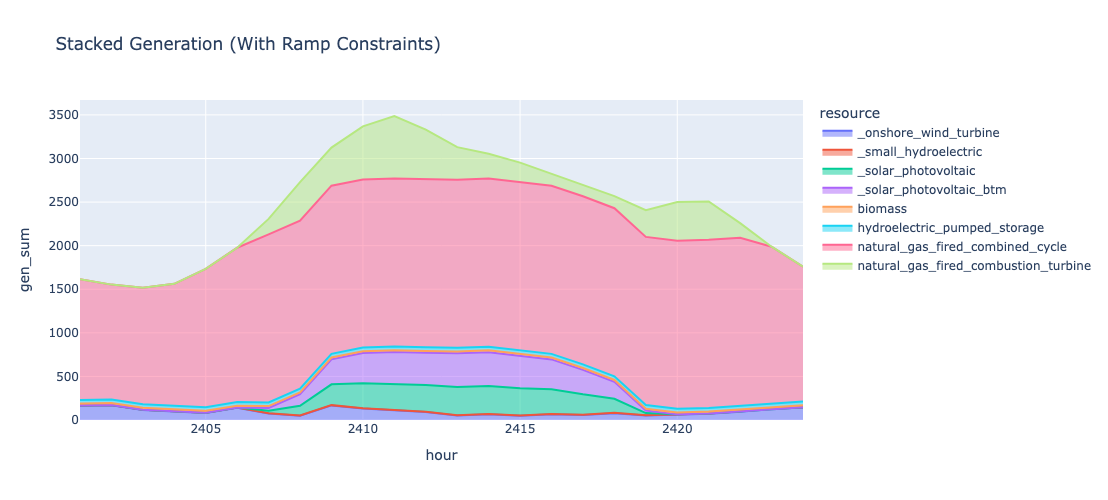

In [62]:
sol_gen_btm_ramp = process_and_plot(solution_ramp, gen_df, gen_variable_multi, T_period,
                                     'Stacked Generation (With Ramp Constraints)')

### Compare LMPs: with vs. without ramp constraints

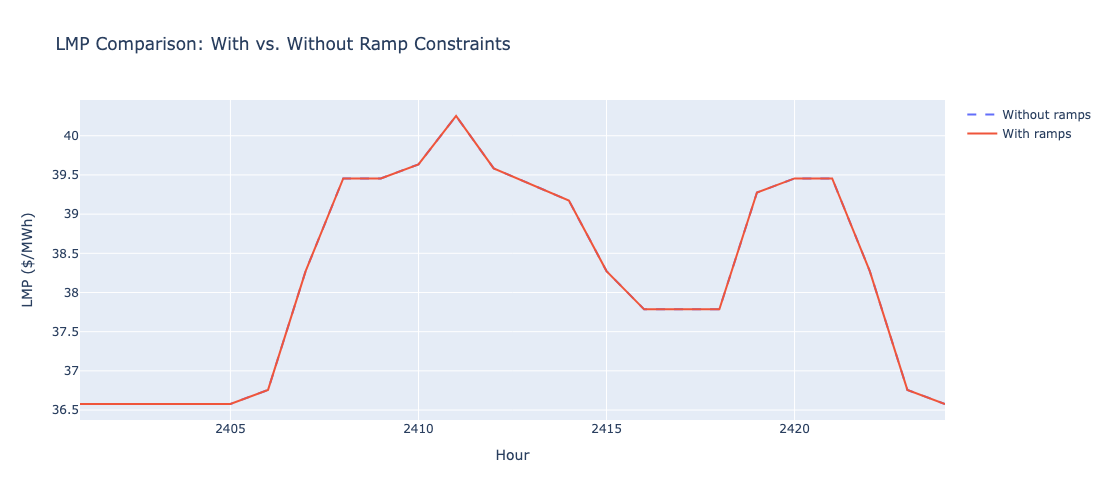

Cost without ramps: $1,374,096.10
Cost with ramps:    $1,374,096.10
Cost increase:      $0.00 (0.00%)


In [63]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=solution_multi['lmps']['hour'], y=solution_multi['lmps']['lmp'],
                         name='Without ramps', line=dict(dash='dash')))
fig.add_trace(go.Scatter(x=solution_ramp['lmps']['hour'], y=solution_ramp['lmps']['lmp'],
                         name='With ramps'))
fig.update_layout(title='LMP Comparison: With vs. Without Ramp Constraints',
                  xaxis_title='Hour', yaxis_title='LMP ($/MWh)',
                  width=1000, height=500)
fig.show()

print(f"Cost without ramps: ${solution_multi['cost']:,.2f}")
print(f"Cost with ramps:    ${solution_ramp['cost']:,.2f}")
print(f"Cost increase:      ${solution_ramp['cost'] - solution_multi['cost']:,.2f} "
      f"({(solution_ramp['cost'] - solution_multi['cost'])/solution_multi['cost']*100:.2f}%)")

### 5. Run sensitivity on solar capacity &mdash; The Duck Curve

Let's now examine what happens if we increase utility solar capacity from the current 500MW up to 3,500MW.

The large reduction in net load during the day and the loss of solar in the late afternoon timed with the rise in the evening peak is sometimes called the **"duck curve"** because of their passing resemblance to a duck's belly and head:

<img src="https://www.energy.gov/sites/prod/files/styles/borealis_photo_gallery_large_respondmedium/public/CAISO_DuckCurve_720_469_80.jpg?itok=99uYAxGo" style="width: 450px; height: auto" align="left">

---
### Quiz 5: Before the Duck Curve

**Predict:**

1. If we increase solar from 500 MW to 3,500 MW, what happens to midday LMPs? What about evening LMPs?
2. Will the total daily cost go up or down?
3. With 3,500 MW of solar, is it possible that some solar generation gets "wasted" (i.e., available solar exceeds demand)? What would happen to the LMP in that case?

---

### Quiz 5 -- Answer Key

**1. What happens to midday and evening LMPs with 3,500 MW solar?**

- **Midday LMPs collapse** toward $0 (or even negative in some market designs). With 3,500 MW of solar capacity and ~500 MW of other renewables, cheap zero-cost generation floods the market at midday. The marginal generator shifts to a very cheap unit, and the LMP drops dramatically.
- **Evening LMPs spike** because solar disappears at sunset while demand stays high. All the gas plants that were idle during the day must now ramp up quickly. Combined-cycle plants can't ramp fast enough (ramp constraints), so expensive combustion turbines set the price.

**2. Will total daily cost go up or down?**

**Down overall.** More solar means more zero-cost energy, which displaces expensive gas generation during the day. However, the cost *savings* at midday are partially offset by *higher costs* in the evening (due to the need for fast-ramping, expensive generators). The net effect is still a reduction in total daily cost, but with much more price volatility.

**3. Can solar generation get "wasted"? What happens to the LMP?**

Yes — this is called **renewable curtailment**. If solar output exceeds demand (minus minimum thermal generation), excess solar must be curtailed. In our model with Pmin = 0, this is less likely because thermal plants can theoretically reduce to zero. But with Pmin > 0 (realistic), over-generation becomes a real problem.

When solar supply exceeds demand, the LMP drops to **$0** because the marginal cost of the next MW is zero (there's already excess supply). In real markets with negative pricing allowed, LMPs can go *negative* — meaning generators are *paid to reduce* output. This actually happens in CAISO on sunny spring days!

In [64]:
# Increase solar photovoltaic capacity
gen_df_duck = gen_df.copy()
gen_df_duck.loc[gen_df_duck['resource'] == 'solar_photovoltaic', 'existing_cap_mw'] = 3500

solution_duck = economic_dispatch_multi_time(gen_df_duck, loads_multi, gen_variable_multi)

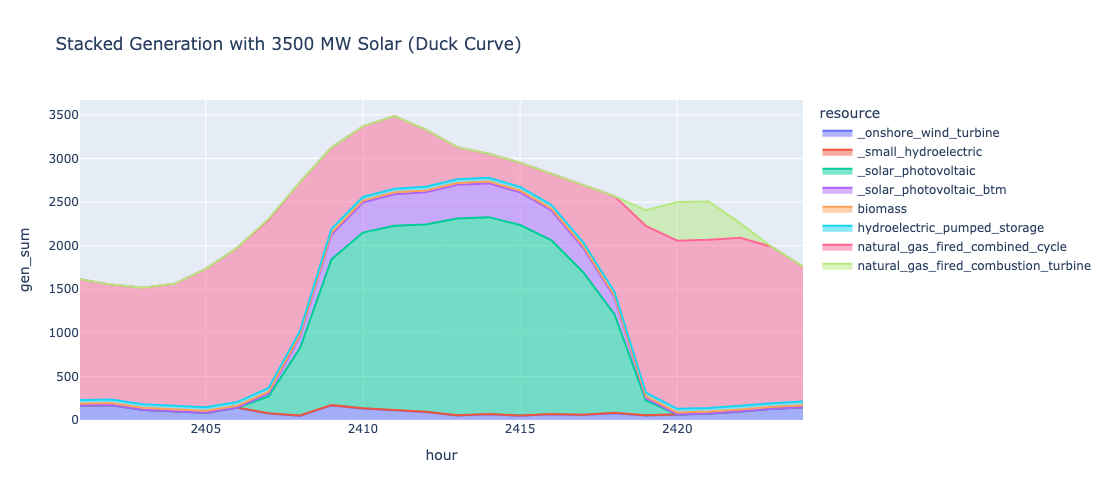

In [65]:
sol_gen_btm_duck = process_and_plot(solution_duck, gen_df, gen_variable_multi, T_period,
                                     'Stacked Generation with 3500 MW Solar (Duck Curve)')

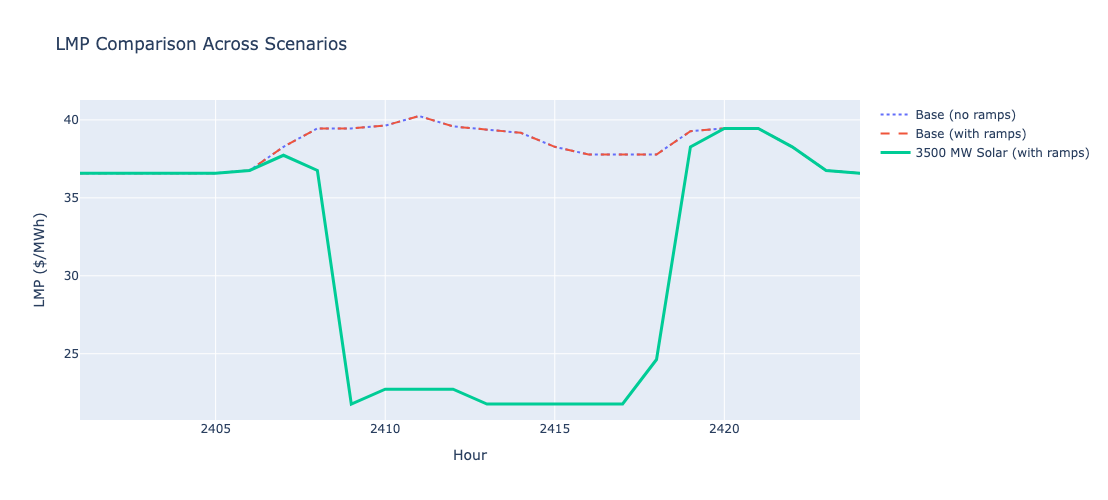

In [66]:
# Compare LMPs across all three scenarios
fig = go.Figure()
fig.add_trace(go.Scatter(x=solution_multi['lmps']['hour'], y=solution_multi['lmps']['lmp'],
                         name='Base (no ramps)', line=dict(dash='dot')))
fig.add_trace(go.Scatter(x=solution_ramp['lmps']['hour'], y=solution_ramp['lmps']['lmp'],
                         name='Base (with ramps)', line=dict(dash='dash')))
fig.add_trace(go.Scatter(x=solution_duck['lmps']['hour'], y=solution_duck['lmps']['lmp'],
                         name='3500 MW Solar (with ramps)', line=dict(width=3)))
fig.update_layout(title='LMP Comparison Across Scenarios',
                  xaxis_title='Hour', yaxis_title='LMP ($/MWh)',
                  width=1000, height=500)
fig.show()

Notice how with high solar penetration:
- **Midday LMPs collapse** as cheap solar displaces expensive gas generation
- **Evening LMPs spike** as solar drops off and gas plants must ramp up quickly
- The **price spread** between midday and evening increases dramatically

This price pattern is exactly what incentivizes **energy storage** investment in real markets.

### Ramp constraint marginal values

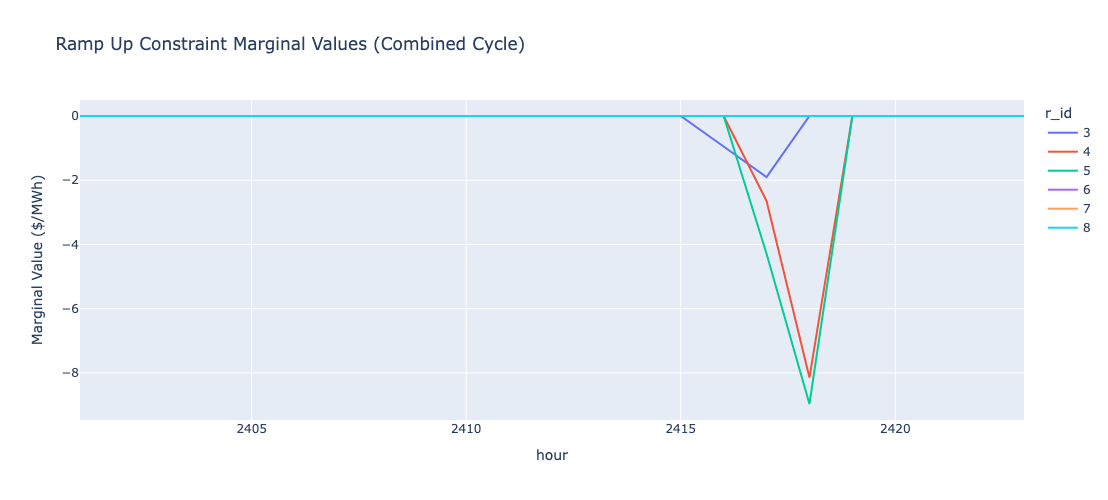

In [67]:
marg_gen = solution_duck['marginals'].merge(gen_df[['r_id', 'resource']], on='r_id')
cc_marginals = marg_gen[marg_gen['resource'] == 'natural_gas_fired_combined_cycle']

fig = px.line(cc_marginals, x='hour', y='dual', color='r_id',
              title='Ramp Up Constraint Marginal Values (Combined Cycle)',
              labels={'dual': 'Marginal Value ($/MWh)'},
              width=800, height=500)
fig.show()

During the ramp hours, the marginal value becomes negative. The interpretation:

**If the RHS of the RampUp constraint were increased by 1 unit, the problem objective would reduce by that amount.**

This happens because ramp-limited combined cycle plants must be substituted by more expensive combustion turbines.

In [68]:
# Show the most binding ramp constraint
worst_ramp = marg_gen.loc[marg_gen['dual'].idxmin()]
print(f"Most binding ramp constraint: r_id={worst_ramp['r_id']}, hour={worst_ramp['hour']}")
print(f"Marginal value: {worst_ramp['dual']:.4f} $/MWh")

# Verify by cost difference
varcost_comp = supply_curve[supply_curve['r_id'].isin([5, 9])][['r_id', 'varcost']]
print(f"\nCost difference between r_id=9 and r_id=5: {varcost_comp['varcost'].iloc[1] - varcost_comp['varcost'].iloc[0]:.4f} $/MWh")
print("(This should match the magnitude of the ramp marginal!)")

Most binding ramp constraint: r_id=5, hour=2418
Marginal value: -8.9672 $/MWh

Cost difference between r_id=9 and r_id=5: 8.9672 $/MWh
(This should match the magnitude of the ramp marginal!)


---
## Real-World Comparison: CAISO Data (2023-2024)

Let's now pull **actual CAISO generation and demand data** from 2023-2024 to see how real California operations compare with our model. We use the open-source [`gridstatus`](https://github.com/gridstatus/gridstatus) library to fetch this data directly.

*Note: The data download may take a minute. If `gridstatus` is unavailable, the cell will produce a message and you can skip to the next section.*

In [69]:
try:
    import gridstatus
    caiso = gridstatus.CAISO()

    # Fetch a spring day in 2024 for comparison (April 11, 2024)
    caiso_demand = caiso.get_load(date="Apr 11, 2024", end="Apr 12, 2024")
    caiso_fuel_mix = caiso.get_fuel_mix(date="Apr 11, 2024", end="Apr 12, 2024")

    # Resample to hourly if data is sub-hourly
    caiso_demand = caiso_demand.set_index('Time')
    if len(caiso_demand) > 30:  # sub-hourly data
        caiso_demand_hourly = caiso_demand.resample('h').mean()
    else:
        caiso_demand_hourly = caiso_demand
    caiso_demand_hourly['hour_of_day'] = caiso_demand_hourly.index.hour

    caiso_fuel_mix = caiso_fuel_mix.set_index('Time')
    if len(caiso_fuel_mix) > 30:
        caiso_fuel_hourly = caiso_fuel_mix.resample('h').mean()
    else:
        caiso_fuel_hourly = caiso_fuel_mix
    caiso_fuel_hourly['hour_of_day'] = caiso_fuel_hourly.index.hour

    caiso_available = True
    print(f"Successfully loaded CAISO data!")
    print(f"Demand range: {caiso_demand_hourly['Load'].min():.0f} - {caiso_demand_hourly['Load'].max():.0f} MW")
    print(f"\nFuel mix columns: {[c for c in caiso_fuel_hourly.columns if c != 'hour_of_day']}")

except Exception as e:
    caiso_available = False
    print(f"Could not load CAISO data: {e}")
    print("Skipping real-world comparison. You can still run all model sections above.")

2026-02-25 15:12:25 - INFO - Fetching URL: https://www.caiso.com/outlook/history/20240411/demand.csv?_=1772021545


Error: HTTP Error 403: Forbidden
Args: {'self': <gridstatus.caiso.CAISO object at 0x114240910>, 'date': Timestamp('2024-04-11 00:00:00-0700', tz='US/Pacific')}

Errors that occurred while getting data:
[{'date': Timestamp('2024-04-11 00:00:00-0700', tz='US/Pacific'),
  'self': <gridstatus.caiso.CAISO object at 0x114240910>}]
Could not load CAISO data: No objects to concatenate
Skipping real-world comparison. You can still run all model sections above.


In [70]:
if caiso_available:
    # Plot CAISO actual fuel mix as stacked area
    fuel_cols = [c for c in caiso_fuel_hourly.columns if c not in ['hour_of_day']]
    fuel_long = caiso_fuel_hourly[fuel_cols].reset_index().melt(
        id_vars='Time', var_name='fuel', value_name='MW'
    )

    fig = px.area(fuel_long, x='Time', y='MW', color='fuel',
                  title='Actual CAISO Generation Mix (April 11, 2024)',
                  width=1000, height=500)
    fig.show()
else:
    print("CAISO data not available. Skipping this plot.")

CAISO data not available. Skipping this plot.


In [71]:
if caiso_available:
    # Plot demand comparison
    fig = go.Figure()
    fig.add_trace(go.Scatter(
        x=caiso_demand_hourly['hour_of_day'],
        y=caiso_demand_hourly['Load'],
        name='CAISO Actual (Apr 2024)', line=dict(width=3)
    ))
    fig.add_trace(go.Scatter(
        x=list(range(24)),
        y=loads_multi['demand'].values,
        name='SDG&E Model (spring day)', line=dict(width=3, dash='dash')
    ))
    fig.update_layout(
        title='Demand Comparison: CAISO Actual vs. Model',
        xaxis_title='Hour of Day',
        yaxis_title='Demand (MW)',
        width=1000, height=500
    )
    fig.show()
    print("Note: CAISO covers all of California (~30 GW peak), while our model covers only SDG&E (~3 GW peak).")
    print("The shape of the demand curve is what matters for comparison, not the absolute MW values.")
else:
    print("CAISO data not available. Skipping this plot.")

CAISO data not available. Skipping this plot.


### Key observations from the real CAISO data

Compare the actual CAISO generation mix with your model results:

1. **Solar dominance at midday**: In the real CAISO data, solar provides a large fraction of midday generation, just as in our model.
2. **The duck curve is real**: The net load (demand minus solar and wind) creates the characteristic duck shape.
3. **Gas ramping**: Natural gas plants ramp up sharply in the evening, consistent with our ramp constraint analysis.
4. **Scale difference**: CAISO covers all of California (~30 GW peak) while our SDG&E model covers ~3 GW. The *patterns* are similar even though the scale differs.

---
## "Break the Model" Exercises

The best way to understand an optimization model is to see what happens when things go wrong. In this section, we deliberately create problematic scenarios to observe how the solver responds and build intuition about constraints.

---

### Exercise 1: Demand exceeds total capacity (Infeasibility)

**What happens if demand is higher than the total available generation capacity?**

---
### Quiz 6: Predict the outcome

The total installed capacity in our system is about 3,400 MW. If we set demand to 5,000 MW:
1. Will the solver find a solution?
2. If not, what does the solver tell us? What real-world situation does this represent?
3. How do real system operators handle this situation?

---

### Quiz 6 -- Answer Key

**1. Will the solver find a solution?**

**No.** The problem is **infeasible**. Total installed capacity is ~3,400 MW, but we're asking for 5,000 MW. Even if every single generator runs at full capacity, we cannot meet demand. The equality constraint $\sum_g GEN_g = 5000$ cannot be satisfied when $\sum_g Pmax_g \approx 3400$.

**2. What does the solver tell us? What real-world situation does this represent?**

The solver returns status **"infeasible"**, meaning no feasible solution exists. In the real world, this represents a situation where **demand exceeds supply** — a capacity shortage. This could happen during:
- Extreme heat waves (record AC demand)
- Unexpected generator outages (forced outages)
- Fuel supply disruptions

The result would be **rolling blackouts** (controlled load shedding) — the operator disconnects some customers to protect the overall grid from collapse.

**3. How do real system operators handle this?**

Real operators have several "safety valves":
- **Imports from neighboring regions** via transmission interconnections (covered in OPF seminar)
- **Demand response programs** — paying large consumers to reduce load
- **Emergency reserves** — generators held in reserve for exactly this situation
- **Load shedding** (rolling blackouts) — as a last resort, the operator disconnects portions of the grid
- **Price caps / Value of Lost Load (VOLL)** — in market models, a very high price (e.g., $9,000/MWh) is used as a penalty for unserved energy, which both signals scarcity and keeps the model feasible

In [72]:
# Total available capacity
total_cap = gen_df['existing_cap_mw'].sum()
print(f"Total installed capacity: {total_cap:.1f} MW")
print(f"Setting demand to 5,000 MW (exceeds capacity by {5000 - total_cap:.1f} MW)")
print("="*60)

# Create infeasible demand
loads_infeasible = pd.DataFrame({'demand': [5000]})
result_infeasible = economic_dispatch_single(gen_df, loads_infeasible, var_cf_single)

print(f"\nSolver status: {result_infeasible['status']}")
if result_infeasible['cost'] is None:
    print("\nThe model is INFEASIBLE. There is no way to meet 5,000 MW of demand")
    print("with only {:.0f} MW of capacity. In the real world, this would mean".format(total_cap))
    print("rolling blackouts or emergency imports from neighboring regions.")
    print("\nIn our OPF seminar, we will see how transmission interconnections")
    print("with neighboring regions help prevent this situation.")

Total installed capacity: 3505.2 MW
Setting demand to 5,000 MW (exceeds capacity by 1494.8 MW)


RuntimeError: A feasible solution was not found, so no solution can be loaded. If using the appsi.solvers.Highs interface, you can set opt.config.load_solution=False. If using the environ.SolverFactory interface, you can set opt.solve(model, load_solutions = False). Then you can check results.termination_condition and results.best_feasible_objective before loading a solution.

### Exercise 2: Remove all ramp limits

**What if generators could ramp infinitely fast?**

This is equivalent to running the multi-period model *without* ramp constraints (which we already did!). Let's compare the costs and dispatch patterns directly.

In [ ]:
print("=" * 60)
print("COMPARISON: With vs. Without Ramp Constraints")
print("=" * 60)
print(f"\nCost WITHOUT ramp limits: ${solution_multi['cost']:>15,.2f}")
print(f"Cost WITH ramp limits:    ${solution_ramp['cost']:>15,.2f}")
print(f"Additional cost of ramps: ${solution_ramp['cost'] - solution_multi['cost']:>15,.2f}")
print(f"\nThis {(solution_ramp['cost'] - solution_multi['cost'])/solution_multi['cost']*100:.2f}% cost increase")
print("represents the 'price of inflexibility' -- the cost of engineering")
print("limitations on how fast generators can change output.")
print("\nIn practice, removing ramp limits is unrealistic.")
print("However, more flexible generators (like batteries) can reduce this cost.")

### Exercise 3: Set Pmin > 0 for thermal plants

In reality, thermal generators (gas, coal, nuclear) often have a **minimum stable output**. A gas turbine might need to run at a minimum of 30-50% of its capacity once it is turned on. Setting $Pmin = 0$ is an approximation we made for simplicity.

---
### Quiz 7: Predict the impact of Pmin > 0

If we set Pmin to 40% of Pmax for all gas generators:
1. Will the total cost increase or decrease? By how much (your guess)?
2. During midday when solar is abundant, what problem does a high Pmin create?
3. If gas plants *must* run at 40% minimum, and solar is producing more than enough... what gives?

*Hint: Think about what we assumed about Pmin for renewables.*

---

### Quiz 7 -- Answer Key

**1. Will the total cost increase or decrease? By how much?**

**Increase.** With Pmin = 40%, thermal generators are *forced* to produce at least 40% of their capacity even when it's not economically efficient. This means:
- During low-demand hours, expensive generators must still run at their minimum, wasting fuel
- The optimizer loses flexibility to turn down cheap generators and turn off expensive ones

The cost increase is typically modest with base solar (a few percent) because thermal plants were mostly running anyway. But it becomes dramatic with high solar.

**2. During midday when solar is abundant, what problem does a high Pmin create?**

The **over-generation problem**. At midday, solar provides abundant cheap energy and demand may be moderate. If all thermal plants must run at 40% of Pmax:
- Minimum thermal output ≈ 40% × ~2,600 MW (total thermal) ≈ ~1,040 MW
- Add solar output at midday ≈ ~1,500–2,500 MW (depending on capacity)
- Total minimum supply can **exceed demand**

Since generation must equal demand (equality constraint), and we can't force generators *below* their Pmin, the model becomes **infeasible**.

**3. If gas plants must run at 40% minimum and solar produces more than enough... what gives?**

Something has to give — and in our continuous ED model, nothing can. The model simply declares infeasibility. In reality, operators have three options:
1. **Curtail renewables** — reduce solar/wind output below what's available (waste free energy)
2. **Shut down thermal units entirely** — but this requires a **unit commitment** model with binary ON/OFF variables (GEN = 0 is allowed, but only if the unit is OFF; if it's ON, GEN ≥ Pmin)
3. **Export power** to neighboring regions via transmission (covered in OPF)

This is exactly why we need **unit commitment** (next seminar): the binary decision to turn a plant ON or OFF allows the system to completely de-commit thermal units when renewables are sufficient, avoiding the over-generation problem.

In [74]:
def economic_dispatch_with_pmin(gen_df, loads, gen_variable, pmin_fraction=0.0):
    """
    ED with ramp constraints AND minimum generation constraints for thermal plants.
    pmin_fraction: fraction of Pmax that thermal plants must generate when on.
    
    NOTE: This is still a continuous relaxation (no binary on/off decision).
    The proper treatment requires unit commitment (integer variables),
    which we will cover in the next seminar.
    """
    model = pyo.ConcreteModel()
    model.dual = pyo.Suffix(direction=pyo.Suffix.IMPORT)

    G_var = list(gen_df[gen_df['is_variable'] == True]['r_id'])
    G_nonvar = list(gen_df[gen_df['is_variable'] == False]['r_id'])
    G = list(gen_df['r_id'])
    T = list(loads['hour'])
    T_red = T[:-1]

    model.G = pyo.Set(initialize=G)
    model.T = pyo.Set(initialize=T, ordered=True)

    gen_var_cf = gen_variable.merge(
        gen_df[gen_df['is_variable'] == True][['r_id', 'gen_full', 'existing_cap_mw']],
        on='gen_full', how='inner'
    )

    gen_lookup = gen_df.set_index('r_id')
    loads_lookup = loads.set_index('hour')

    # Decision variables
    model.GEN = pyo.Var(model.G, model.T, within=pyo.NonNegativeReals)

    # Objective
    def obj_rule(m):
        return (
            sum(
                (gen_lookup.loc[i, 'heat_rate_mmbtu_per_mwh'] * gen_lookup.loc[i, 'fuel_cost'] +
                 gen_lookup.loc[i, 'var_om_cost_per_mwh']) * m.GEN[i, t]
                for i in G_nonvar for t in T
            ) +
            sum(
                gen_lookup.loc[i, 'var_om_cost_per_mwh'] * m.GEN[i, t]
                for i in G_var for t in T
            )
        )
    model.objective = pyo.Objective(rule=obj_rule, sense=pyo.minimize)

    # Demand constraint
    model.cDemand = pyo.Constraint(model.T)
    for t in T:
        model.cDemand[t] = sum(model.GEN[i, t] for i in G) == loads_lookup.loc[t, 'demand']

    # Capacity constraints (non-variable) -- upper bound
    model.cap_nonvar_upper = pyo.ConstraintList()
    for i in G_nonvar:
        for t in T:
            model.cap_nonvar_upper.add(model.GEN[i, t] <= gen_lookup.loc[i, 'existing_cap_mw'])

    # Minimum generation constraints for thermal plants
    model.pmin = pyo.ConstraintList()
    for i in G_nonvar:
        for t in T:
            model.pmin.add(
                model.GEN[i, t] >= pmin_fraction * gen_lookup.loc[i, 'existing_cap_mw']
            )

    # Variable generation capacity constraints
    model.cap_var = pyo.ConstraintList()
    for _, row in gen_var_cf.iterrows():
        model.cap_var.add(
            model.GEN[row['r_id'], row['hour']] <= row['cf'] * row['existing_cap_mw']
        )

    # Ramp constraints
    model.ramp_up = pyo.Constraint(model.G, T_red)
    model.ramp_dn = pyo.Constraint(model.G, T_red)
    for i in G:
        for idx, t in enumerate(T_red):
            t_next = T[idx + 1]
            model.ramp_up[i, t] = (
                model.GEN[i, t_next] - model.GEN[i, t] <=
                gen_lookup.loc[i, 'existing_cap_mw'] * gen_lookup.loc[i, 'ramp_up_percentage']
            )
            model.ramp_dn[i, t] = (
                model.GEN[i, t] - model.GEN[i, t_next] <=
                gen_lookup.loc[i, 'existing_cap_mw'] * gen_lookup.loc[i, 'ramp_dn_percentage']
            )

    # Solve
    solver = pyo.SolverFactory('appsi_highs')
    result = solver.solve(model, tee=False)

    status = str(result.solver.termination_condition)
    if status != 'optimal':
        print(f"\n*** Solver status: {status} ***")
        return {'solution': pd.DataFrame(), 'cost': None, 'lmps': pd.DataFrame(), 'status': status}

    records = []
    for i in G:
        for t in T:
            records.append({'r_id': i, 'hour': t, 'gen': pyo.value(model.GEN[i, t])})

    lmps = pd.DataFrame({'hour': T, 'lmp': [model.dual[model.cDemand[t]] for t in T]})

    return {
        'solution': pd.DataFrame(records),
        'cost': pyo.value(model.objective),
        'lmps': lmps,
        'status': status,
    }

In [ ]:
# Test with Pmin = 40% for thermal plants (base solar)
print("Solving with Pmin = 40% of Pmax for all thermal generators...")
solution_pmin = economic_dispatch_with_pmin(gen_df, loads_multi, gen_variable_multi, pmin_fraction=0.4)
print(f"Status: {solution_pmin['status']}")
if solution_pmin['cost']:
    print(f"Cost: ${solution_pmin['cost']:,.2f}")

In [ ]:
# Now try with high solar AND Pmin -- this can become infeasible!
print("Solving with Pmin = 40% AND 3500 MW solar...")
print("(This may be infeasible if thermal minimum output + solar > demand at midday)")
print("=" * 60)

solution_pmin_duck = economic_dispatch_with_pmin(gen_df_duck, loads_multi, gen_variable_multi, pmin_fraction=0.4)
print(f"\nStatus: {solution_pmin_duck['status']}")

if solution_pmin_duck['status'] != 'optimal':
    print("\nThe model is INFEASIBLE! This is because:")
    min_thermal = gen_df[gen_df['is_variable'] == False]['existing_cap_mw'].sum() * 0.4
    print(f"  - Minimum thermal output (40%): {min_thermal:.0f} MW")
    print(f"  - Minimum demand: {loads_multi['demand'].min():.0f} MW")
    print(f"  - Plus solar can add up to ~2,000 MW at midday")
    print(f"  - Total minimum supply can exceed demand!")
    print("\nIn reality, this is the 'over-generation' problem that CAISO faces.")
    print("Solutions include: curtailing renewables, exporting power, or shutting")
    print("down thermal units -- which requires unit commitment (next seminar!).")
else:
    print(f"Cost: ${solution_pmin_duck['cost']:,.2f}")
    sol_gen_btm_pmin = process_and_plot(solution_pmin_duck, gen_df, gen_variable_multi, T_period,
                                        'Generation with Pmin=40% and 3500 MW Solar')

**Key insight**: The Pmin constraint is a simplified version of the **unit commitment** problem. In reality, generators are either ON (operating between Pmin and Pmax) or OFF (generating 0). This ON/OFF decision requires **binary variables**, making it a mixed-integer program (MIP). We will cover this in the **Unit Commitment seminar**.

---
## Scenario Comparison Table

Let's now compile a summary table comparing all the scenarios we have run, side by side.

---

In [ ]:
# Build comparison table
scenarios = {}

# 1. Base case (no ramps)
scenarios['Base (no ramps)'] = solution_multi

# 2. Base case (with ramps)
scenarios['Base (with ramps)'] = solution_ramp

# 3. Duck curve (3500 MW solar, with ramps)
scenarios['3500 MW Solar'] = solution_duck

# 4. Pmin = 40% (base solar)
if solution_pmin['cost'] is not None:
    scenarios['Pmin=40% (base solar)'] = solution_pmin

# Build table rows
rows = []
for name, sol in scenarios.items():
    lmps = sol['lmps']
    row = {
        'Scenario': name,
        'Total Cost ($)': f"${sol['cost']:,.0f}",
        'Avg LMP ($/MWh)': f"${lmps['lmp'].mean():.2f}",
        'Min LMP ($/MWh)': f"${lmps['lmp'].min():.2f}",
        'Max LMP ($/MWh)': f"${lmps['lmp'].max():.2f}",
        'LMP Spread': f"${lmps['lmp'].max() - lmps['lmp'].min():.2f}",
        'Status': sol['status'],
    }
    rows.append(row)

# Add infeasible scenarios
if result_infeasible['cost'] is None:
    rows.append({
        'Scenario': 'Demand > Capacity',
        'Total Cost ($)': 'N/A',
        'Avg LMP ($/MWh)': 'N/A',
        'Min LMP ($/MWh)': 'N/A',
        'Max LMP ($/MWh)': 'N/A',
        'LMP Spread': 'N/A',
        'Status': result_infeasible['status'],
    })

if solution_pmin_duck['cost'] is None:
    rows.append({
        'Scenario': 'Pmin=40% + 3500MW Solar',
        'Total Cost ($)': 'N/A',
        'Avg LMP ($/MWh)': 'N/A',
        'Min LMP ($/MWh)': 'N/A',
        'Max LMP ($/MWh)': 'N/A',
        'LMP Spread': 'N/A',
        'Status': solution_pmin_duck['status'],
    })

comparison_df = pd.DataFrame(rows)
comparison_df

### Reading the comparison table

Key takeaways:

1. **Ramp constraints increase cost**: The "price of inflexibility" -- more expensive generators must substitute for cheaper ones that can't ramp fast enough.

2. **More solar reduces average cost** but increases the **LMP spread** (difference between peak and off-peak prices). This price signal incentivizes storage and demand response.

3. **Pmin constraints can cause infeasibility** when combined with high renewable penetration. This is the **over-generation problem** that motivates:
   - Renewable curtailment
   - Energy storage
   - Unit commitment (turning plants OFF entirely)
   - Demand response

4. **Excess demand causes infeasibility** -- the system simply cannot meet the load. Real-world solutions include:
   - Emergency imports via transmission lines (covered in OPF seminar)
   - Demand-side management / load shedding
   - Peaker plants and demand response (covered in UC seminar)

---
### Quiz 8: Final Reflection

1. In our model, the LMP is determined by the dual of the demand constraint. In a real market with transmission constraints (OPF), why would LMPs differ across different locations (nodes) in the grid?

2. We assumed all generators have Pmin = 0, meaning they can smoothly reduce output to zero. Why is this unrealistic for a coal or nuclear plant? What kind of optimization problem do we need to handle the ON/OFF decision?

3. Looking at the comparison table, the "LMP Spread" increases dramatically with high solar. If you were an energy storage investor, how would you use this information?

4. Our model found two scenarios that were **infeasible**. In real power systems, infeasibility is not an option -- the lights must stay on. What "safety valves" do real system operators use? *(We will explore these in the UC and OPF seminars.)*

---

### Quiz 8 -- Answer Key

**1. Why would LMPs differ across locations in a real market with transmission constraints?**

In our single-bus model, there is one LMP for the whole system because we ignore the transmission network. In reality, **transmission lines have limited capacity** (thermal limits). When a line is congested (at its limit), generators on one side of the congestion cannot deliver power to loads on the other side. This means:
- Cheap generation behind the congestion is "trapped" and cannot serve distant loads
- Expensive local generation must be dispatched instead
- The LMP at the congested load bus is **higher** than at the generation bus

This creates **locational** marginal prices — different prices at different nodes (buses). The LMP at each bus equals: **Energy component + Congestion component + Losses component**. We will see this in the OPF seminar, where Bus 3 in our 3-bus example reaches $150/MWh due to congestion.

**2. Why is Pmin = 0 unrealistic for coal/nuclear? What optimization problem handles ON/OFF?**

Large thermal plants (coal, nuclear, large gas) have significant **minimum stable output** requirements:
- **Nuclear**: typically 50–100% of capacity (essentially must-run)
- **Coal**: typically 40–60% of capacity (boiler stability requirements)
- **Combined cycle gas**: typically 30–50% (heat recovery steam generator constraints)

These plants cannot simply "dial down" to zero — they are either ON (producing between Pmin and Pmax) or OFF (producing 0). This ON/OFF decision requires a **binary variable** (0 or 1), making the problem a **Mixed-Integer Program (MIP)** — specifically, the **Unit Commitment (UC)** problem. UC also accounts for:
- Startup costs (fuel to heat the boiler)
- Minimum up/down times (can't restart immediately after shutdown)
- Startup/shutdown ramp trajectories

**3. How would an energy storage investor use the LMP spread information?**

The LMP spread (max LMP − min LMP) represents the **arbitrage opportunity** for storage:
- **Charge** during low-LMP hours (midday with solar) at ~$0–5/MWh
- **Discharge** during high-LMP hours (evening peak) at ~$40–60/MWh
- **Profit** ≈ LMP spread minus round-trip efficiency losses (~15–20%)

With 3,500 MW solar, the LMP spread is dramatically larger than the base case, meaning storage is much more profitable. An investor would:
1. Use the spread to estimate annual revenue (spread × storage capacity × 365 × utilization)
2. Compare against battery capital costs (~$200–300/kWh for 4-hour lithium-ion)
3. The larger the spread, the faster the payback period
4. Note that as more storage is built, it *compresses* the spread (buy low → raises low prices, sell high → lowers high prices) — so early movers benefit most

**4. What "safety valves" do real system operators use to prevent infeasibility?**

Real power systems have multiple layers of protection:

1. **Transmission interconnections** (OPF) — import power from neighboring regions when local supply is insufficient
2. **Operating reserves** — generators held back from the market, ready to respond within minutes (spinning reserve, non-spinning reserve, regulation)
3. **Unit commitment** — day-ahead scheduling that ensures enough generators are committed (turned ON) to cover forecasted demand plus reserves
4. **Demand response** — contracts with large industrial consumers who agree to reduce load when called upon (in exchange for lower rates)
5. **Renewable curtailment** — reduce solar/wind output when over-generation threatens grid stability
6. **Emergency procedures** — voltage reduction (brownouts), public appeals to conserve, and as a last resort, controlled load shedding (rolling blackouts)
7. **Value of Lost Load (VOLL)** — in optimization models, a very high penalty price ($5,000–$50,000/MWh) is added for unserved energy, keeping the model feasible while signaling extreme scarcity

## Summary

In this seminar, we have:

- Built an **economic dispatch model** from scratch using Pyomo and HiGHS
- Progressed from single-period to multi-period models with increasing realism
- Extracted **Locational Marginal Prices (LMPs)** from constraint duals
- Explored the **duck curve** and its implications for system operations
- Compared model results with **real CAISO data** from 2023-2024
- Identified **model limitations** by deliberately breaking it

### What's next?

- **Unit Commitment**: Adding binary ON/OFF decisions for generators, startup costs, minimum up/down times, and proper Pmin handling
- **Optimal Power Flow**: Adding network topology, transmission constraints, and spatially varying LMPs